In [1]:
!pip install segmentation_models_pytorch
import os
import cv2
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset,DataLoader
import torch
import torch.nn as nn
from torchvision.transforms import transforms
import segmentation_models_pytorch as smp
import segmentation_models_pytorch.utils as utils

device='cuda' if torch.cuda.is_available() else 'cpu'
print(device)

  Obtaining dependency information for segmentation_models_pytorch from https://files.pythonhosted.org/packages/cb/70/4aac1b240b399b108ce58029ae54bc14497e1bbc275dfab8fd3c84c1e35d/segmentation_models_pytorch-0.3.3-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Obtaining dependency information for timm==0.9.2 from https://files.pythonhosted.org/packages/29/90/94f5deb8d76e24a89813aef95e8809ca8fd7414490428480eda19b133d4a/timm-0.9.2-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 7.8 MB/s eta 0:00:00
  Obtaining dependency information for munch from https://files.pythonhosted.org/packages/56/b3/7c69b37f03260a061883bec0e7b05be7117c1b1c85f5212c72c8c2bc3c8c/munch-4.0.0-py2.py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


cuda


In [2]:
image_path='/kaggle/input/car-segmentation/car-segmentation/images/'
mask_path='/kaggle/input/car-segmentation/car-segmentation/masks/'

In [3]:
image_list=[]
imgs=os.listdir(image_path)
for i in imgs:
    image_list.append(i)
    
mask_list=[]
masks=os.listdir(mask_path)
for i in masks:
    mask_list.append(i)
    
print(len(image_list))
print(len(mask_list))

211
211


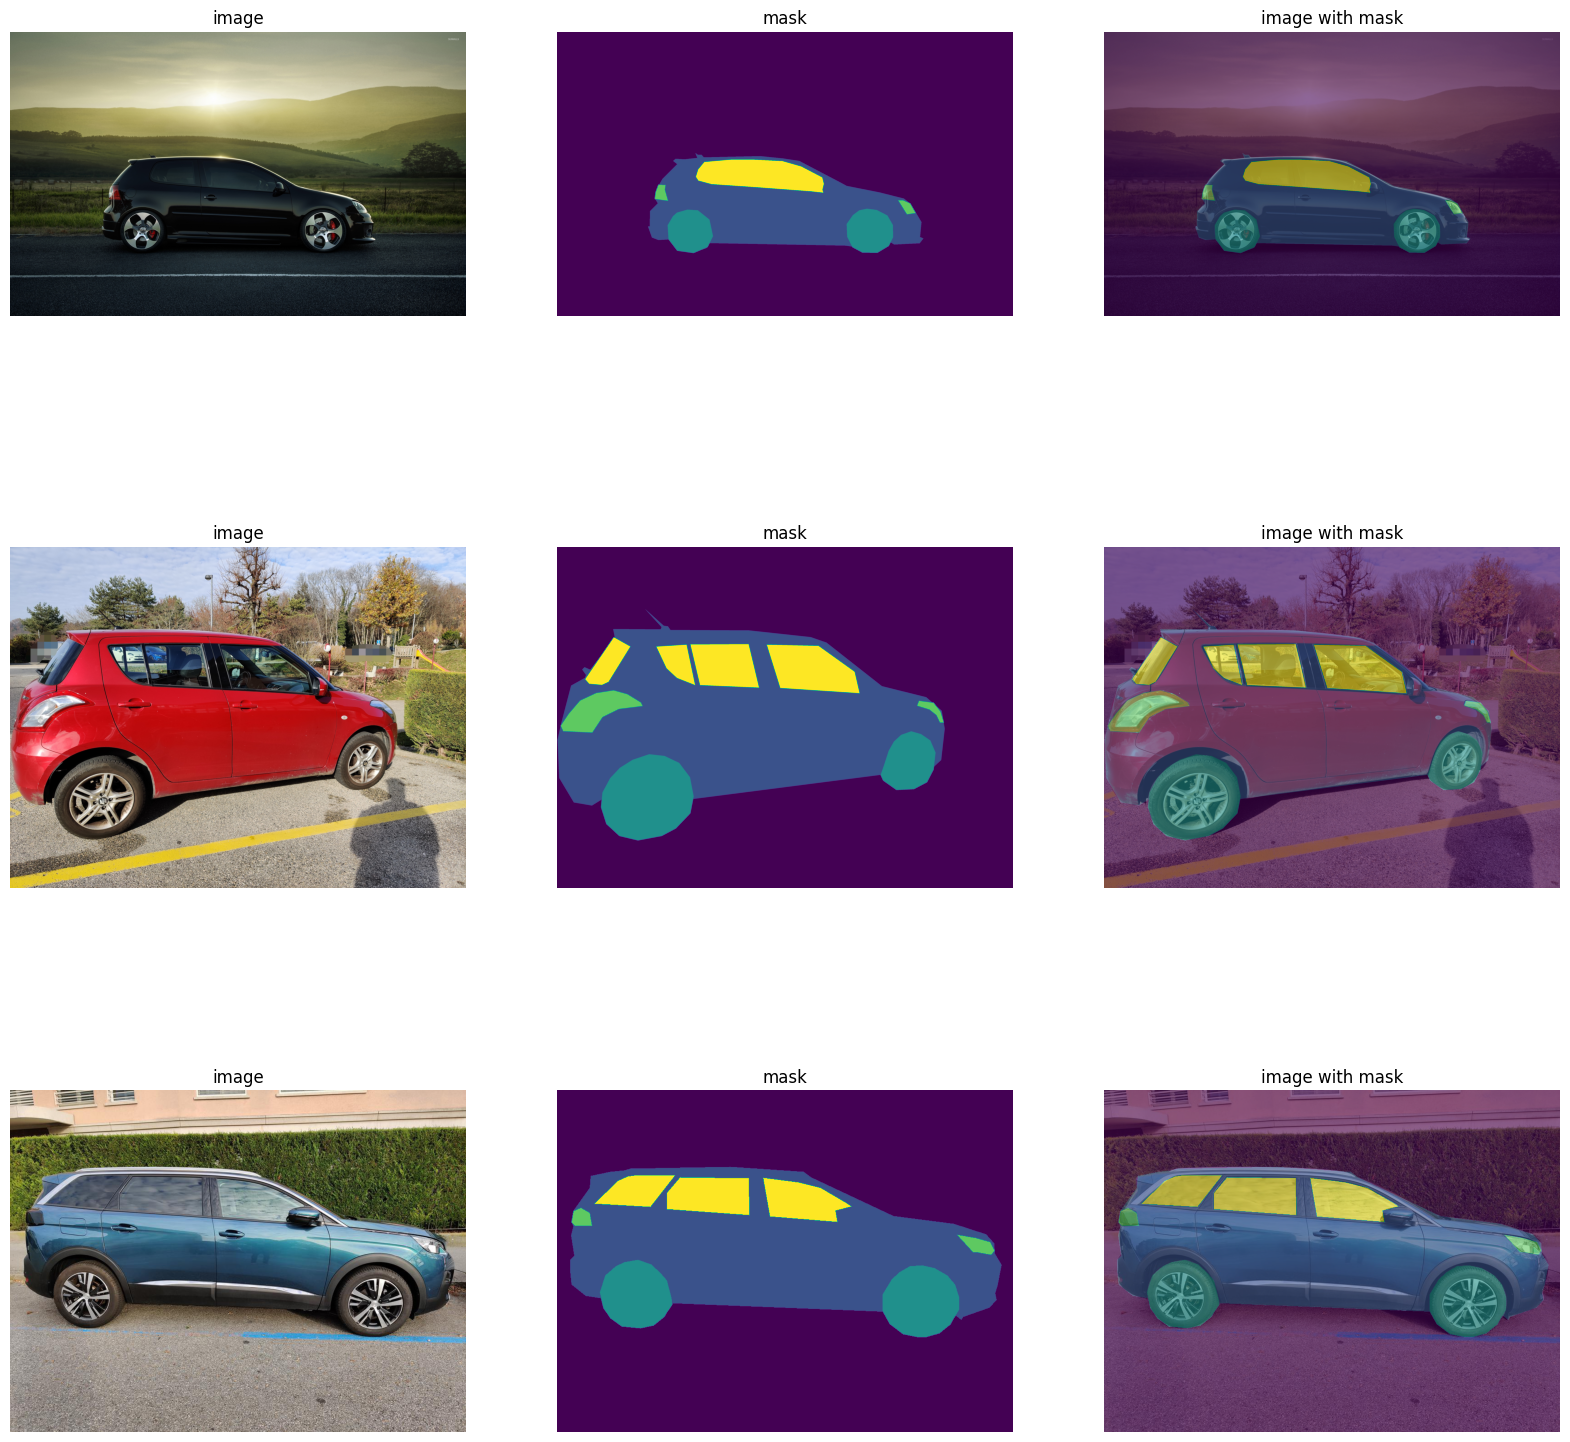

In [4]:
#view image, mask, image with mask
fig,ax=plt.subplots(nrows=3,ncols=3,figsize=(20,20))
for i in range(3):
    img=cv2.imread(image_path+image_list[i])
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    ax[i,0].set_title('image')
    ax[i,0].set_axis_off()
    ax[i,0].imshow(img)
    plt.axis(False)
    mask=cv2.imread(mask_path+mask_list[i])
    mask=cv2.cvtColor(mask,cv2.COLOR_BGR2GRAY)
    ax[i,1].set_title('mask')
    ax[i,1].set_axis_off()
    ax[i,1].imshow(mask)
    plt.axis(False)
    ax[i,2].set_title('image with mask')
    ax[i,2].set_axis_off()
    ax[i,2].imshow(img)
    ax[i,2].imshow(mask,alpha=0.6)
plt.show()

In [5]:
#train_test_split
train_val,test=train_test_split(image_list,test_size=0.1,random_state=19)
train,val=train_test_split(train_val,test_size=0.15,random_state=19)

print('train:',len(train))
print('val:',len(val))
print('test:',len(test))

train: 160
val: 29
test: 22


In [6]:
#dataset creation function
class car_dataset(Dataset):
    def __init__(self,image_path,mask_path,X,size=(256,256)):
        super().__init__()
        self.image_path=image_path
        self.mask_path=mask_path
        self.X=X
        self.size=size
        self.image_transforms=transforms.Compose([transforms.ToTensor(),
                                                  transforms.Resize(self.size,antialias=True)])
    
    def __getitem__(self,idx):
        img=cv2.imread(self.image_path+self.X[idx])
        img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        mask=cv2.imread(self.mask_path+self.X[idx],cv2.IMREAD_GRAYSCALE)
        img=self.image_transforms(img)
        mask=torch.from_numpy(cv2.resize(mask,self.size)).squeeze().long()
        return img,mask
        
    def __len__(self):
        return len(self.X)

In [7]:
#create dataset
train_dataset=car_dataset(image_path,mask_path,train)
val_dataset=car_dataset(image_path,mask_path,val)
test_dataset=car_dataset(image_path,mask_path,test)

print('image.shape:',train_dataset[0][0].shape)
print('mask.shape:',train_dataset[0][1].shape)

image.shape: torch.Size([3, 256, 256])
mask.shape: torch.Size([256, 256])


In [8]:
#create dataloader
batch_size=10
train_dataloader=DataLoader(train_dataset,batch_size=batch_size,num_workers=4,shuffle=True)
val_dataloader=DataLoader(val_dataset,batch_size=batch_size,num_workers=4,shuffle=True)
test_dataloader=DataLoader(test_dataset,batch_size=batch_size,num_workers=4,shuffle=True)

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


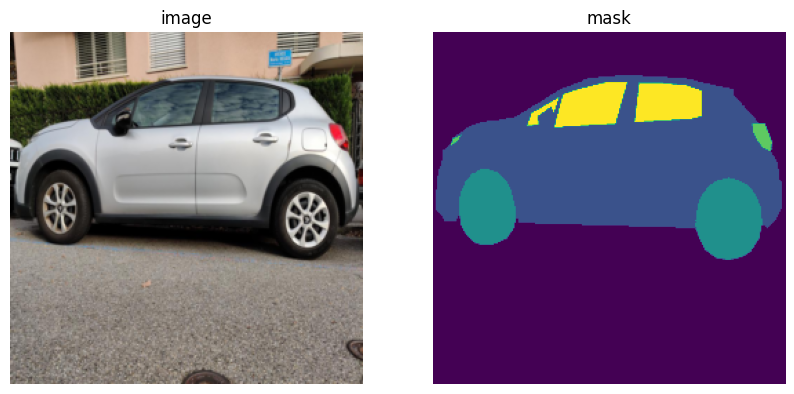

In [9]:
#view image and mask from dataloader
fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(10,10))
for i in train_dataloader:
    img,mask=i
    ax[0].set_title('image')
    ax[0].set_axis_off()
    ax[0].imshow(img[0].permute(1,2,0))
    ax[1].set_title('mask')
    ax[1].set_axis_off()
    ax[1].imshow(mask[0])
    plt.show()
    break

In [10]:
#create UNet model
def double_convolution(in_channels,out_channels):
    conv_op=nn.Sequential(
        nn.Conv2d(in_channels,out_channels,kernel_size=3,padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels,out_channels,kernel_size=3,padding=1),
        nn.ReLU(inplace=True)
    )
    return conv_op


class UNet(nn.Module):
    def __init__(self,num_classes):
        super(UNet,self).__init__()
        self.max_pool2d=nn.MaxPool2d(kernel_size=2, stride=2)
        self.down_convolution_1=double_convolution(3,64)
        self.down_convolution_2=double_convolution(64,128)
        self.down_convolution_3=double_convolution(128,256)
        self.down_convolution_4=double_convolution(256,512)
        self.down_convolution_5=double_convolution(512,1024)
        self.up_transpose_1=nn.ConvTranspose2d(
            in_channels=1024,out_channels=512,
            kernel_size=2,stride=2)
        self.up_convolution_1=double_convolution(1024, 512)
        self.up_transpose_2=nn.ConvTranspose2d(
            in_channels=512,out_channels=256,
            kernel_size=2,stride=2)
        self.up_convolution_2=double_convolution(512, 256)
        self.up_transpose_3=nn.ConvTranspose2d(
            in_channels=256,out_channels=128,
            kernel_size=2,stride=2)
        self.up_convolution_3=double_convolution(256, 128)
        self.up_transpose_4=nn.ConvTranspose2d(
            in_channels=128,out_channels=64,
            kernel_size=2,stride=2)
        self.up_convolution_4=double_convolution(128, 64)
        self.out=nn.Conv2d(in_channels=64,out_channels=num_classes,kernel_size=1) 
        
    def forward(self, x):
        down_1=self.down_convolution_1(x)
        down_2=self.max_pool2d(down_1)
        down_3=self.down_convolution_2(down_2)
        down_4=self.max_pool2d(down_3)
        down_5=self.down_convolution_3(down_4)
        down_6=self.max_pool2d(down_5)
        down_7=self.down_convolution_4(down_6)
        down_8=self.max_pool2d(down_7)
        down_9=self.down_convolution_5(down_8)        

        up_1=self.up_transpose_1(down_9)
        x=self.up_convolution_1(torch.cat([down_7,up_1],1))
        up_2=self.up_transpose_2(x)
        x=self.up_convolution_2(torch.cat([down_5,up_2],1))
        up_3=self.up_transpose_3(x)
        x=self.up_convolution_3(torch.cat([down_3,up_3],1))
        up_4=self.up_transpose_4(x)
        x=self.up_convolution_4(torch.cat([down_1,up_4],1))
        out=self.out(x)
        return out

In [11]:
#model settings
model=UNet(num_classes=5).to(device)
criterion=utils.losses.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=0.0001)

In [12]:
#train and validation
epochs=50
n=0
m=0
history={'train_loss':[]}
for epoch in range(epochs):
    train_loss=0
    val_loss=0
    model.train()
    for i,data in enumerate(train_dataloader):
        images,masks=data
        images=images.to(device)
        masks=masks.to(device)
        optimizer.zero_grad()
        outputs=model(images)
        loss=criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        train_loss+=loss.item()
        history['train_loss'].append(loss.item())
        n+=1
        if (i+1)%(len(train_dataset)//batch_size)==0:
            print('Epoch:',epoch+1 ,'train_loss:',train_loss/n)
            n=0
            train_loss=0
            
    model.eval()
    with torch.no_grad():
        for i,data in enumerate(val_dataloader):
            images,masks=data
            images=images.to(device)
            masks=masks.to(device)
            outputs=model(images)
            loss=criterion(outputs, masks)
            val_loss+=loss.item()
            m+=1
            if (i+1)%(len(val_dataset)//batch_size)==0:
                print('Epoch:',epoch+1 ,'val_loss:',val_loss/m)
                m=0
                val_loss=0
                
print('train and valid finished.')

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: 1 train_loss: 1.590389907360077


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: 1 val_loss: 1.5096208453178406


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: 2 train_loss: 1.1719764582812786


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: 2 val_loss: 0.6806677977244059


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: 3 train_loss: 0.9618814326822758


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: 3 val_loss: 0.6284462610880533


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: 4 train_loss: 0.9330147281289101


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: 4 val_loss: 0.6252266963322958


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: 5 train_loss: 0.8454356417059898


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: 5 val_loss: 0.5894788702329


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: 6 train_loss: 0.7924247905611992


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: 6 val_loss: 0.5752457976341248


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: 7 train_loss: 0.7564669623970985


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: 7 val_loss: 0.542711079120636


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: 8 train_loss: 0.7343540675938129


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: 8 val_loss: 0.5054492751757304


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: 9 train_loss: 0.711888525635004


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: 9 val_loss: 0.4901365240414937


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: 10 train_loss: 0.6967032067477703


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: 10 val_loss: 0.528641402721405


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: 11 train_loss: 0.6840547472238541


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: 11 val_loss: 0.47389763593673706


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: 12 train_loss: 0.6524219252169132


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: 12 val_loss: 0.45867886145909625


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: 13 train_loss: 0.6313464604318142


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: 13 val_loss: 0.47497254610061646


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: 14 train_loss: 0.6202891618013382


libpng warning: iCCP: known incorrect sRGB profile


Epoch: 14 val_loss: 0.43373151620229083


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: 15 train_loss: 0.5860957149416208


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: 15 val_loss: 0.502659281094869


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: 16 train_loss: 0.577894788235426


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: 16 val_loss: 0.43195855617523193


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: 17 train_loss: 0.5443873163312674


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: 17 val_loss: 0.39534324407577515


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: 18 train_loss: 0.5254403855651617


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: 18 val_loss: 0.38161661227544147


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: 19 train_loss: 0.5152684301137924


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: 19 val_loss: 0.39017073313395184


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: 20 train_loss: 0.5205284021794796


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: 20 val_loss: 0.3812914689381917


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: 21 train_loss: 0.48702012561261654


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: 21 val_loss: 0.3707611362139384


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: 22 train_loss: 0.46941493451595306


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: 22 val_loss: 0.32663001616795856


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: 23 train_loss: 0.4687890578061342


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: 23 val_loss: 0.3608953058719635


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: 24 train_loss: 0.4552589375525713


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: 24 val_loss: 0.2930396497249603


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: 25 train_loss: 0.4196731988340616


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: 25 val_loss: 0.3443525830904643


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: 26 train_loss: 0.4159403592348099


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: 26 val_loss: 0.29004106918970746


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: 27 train_loss: 0.3947009015828371


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: 27 val_loss: 0.38397566477457684


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: 28 train_loss: 0.4023668933659792


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: 28 val_loss: 0.29665778080622357


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: 29 train_loss: 0.3732117433100939


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: 29 val_loss: 0.2938870390256246


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: 30 train_loss: 0.36340558528900146


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: 30 val_loss: 0.1934611697991689


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: 31 train_loss: 0.3429040964692831


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: 31 val_loss: 0.23170446356137595


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: 32 train_loss: 0.32575270161032677


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: 32 val_loss: 0.27242835362752277


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: 33 train_loss: 0.3300240207463503


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: 33 val_loss: 0.2895016173521678


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: 34 train_loss: 0.3336394764482975


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: 34 val_loss: 0.2700990041097005


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: 35 train_loss: 0.29897510446608067


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: 35 val_loss: 0.25575195749600727


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: 36 train_loss: 0.2783299498260021


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: 36 val_loss: 0.2417812446753184


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: 37 train_loss: 0.2849330697208643


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: 37 val_loss: 0.1750823309024175


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: 38 train_loss: 0.2685264851897955


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: 38 val_loss: 0.2602989474932353


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: 39 train_loss: 0.2669263957068324


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: 39 val_loss: 0.26088189085324603


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: 40 train_loss: 0.23545998521149158


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: 40 val_loss: 0.24360655744870505


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: 41 train_loss: 0.23078930098563433


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: 41 val_loss: 0.2271522581577301


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: 42 train_loss: 0.21687293238937855


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: 42 val_loss: 0.19706657032171884


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: 43 train_loss: 0.20136611256748438


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: 43 val_loss: 0.18819782137870789


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: 44 train_loss: 0.1873153792694211


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: 44 val_loss: 0.16222615540027618


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: 45 train_loss: 0.1809801645576954


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: 45 val_loss: 0.23508629202842712


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: 46 train_loss: 0.20212703198194504


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: 46 val_loss: 0.21079960465431213


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: 47 train_loss: 0.18579869903624058


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: 47 val_loss: 0.18179675936698914


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: 48 train_loss: 0.17327287700027227


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: 48 val_loss: 0.17124343911806741


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: 49 train_loss: 0.15729032270610332


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: 49 val_loss: 0.1955732653538386


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch: 50 train_loss: 0.15143942600116134


libpng warning: iCCP: known incorrect sRGB profile


Epoch: 50 val_loss: 0.16278656323750815
train and valid finished.


libpng warning: iCCP: known incorrect sRGB profile


Text(0, 0.5, 'train_loss')

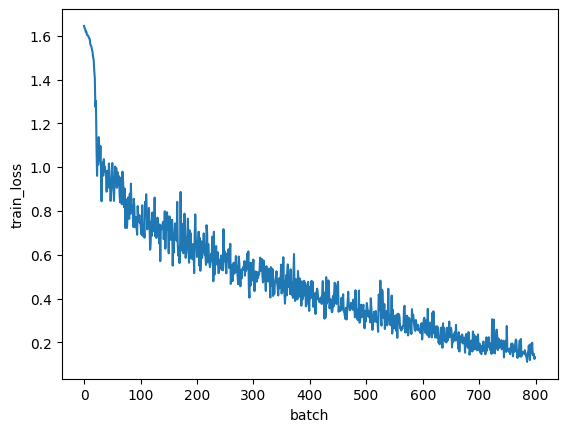

In [13]:
#plot loss
plt.plot(history["train_loss"])
plt.xlabel('batch')
plt.ylabel('train_loss')

libpng warning: iCCP: known incorrect sRGB profile


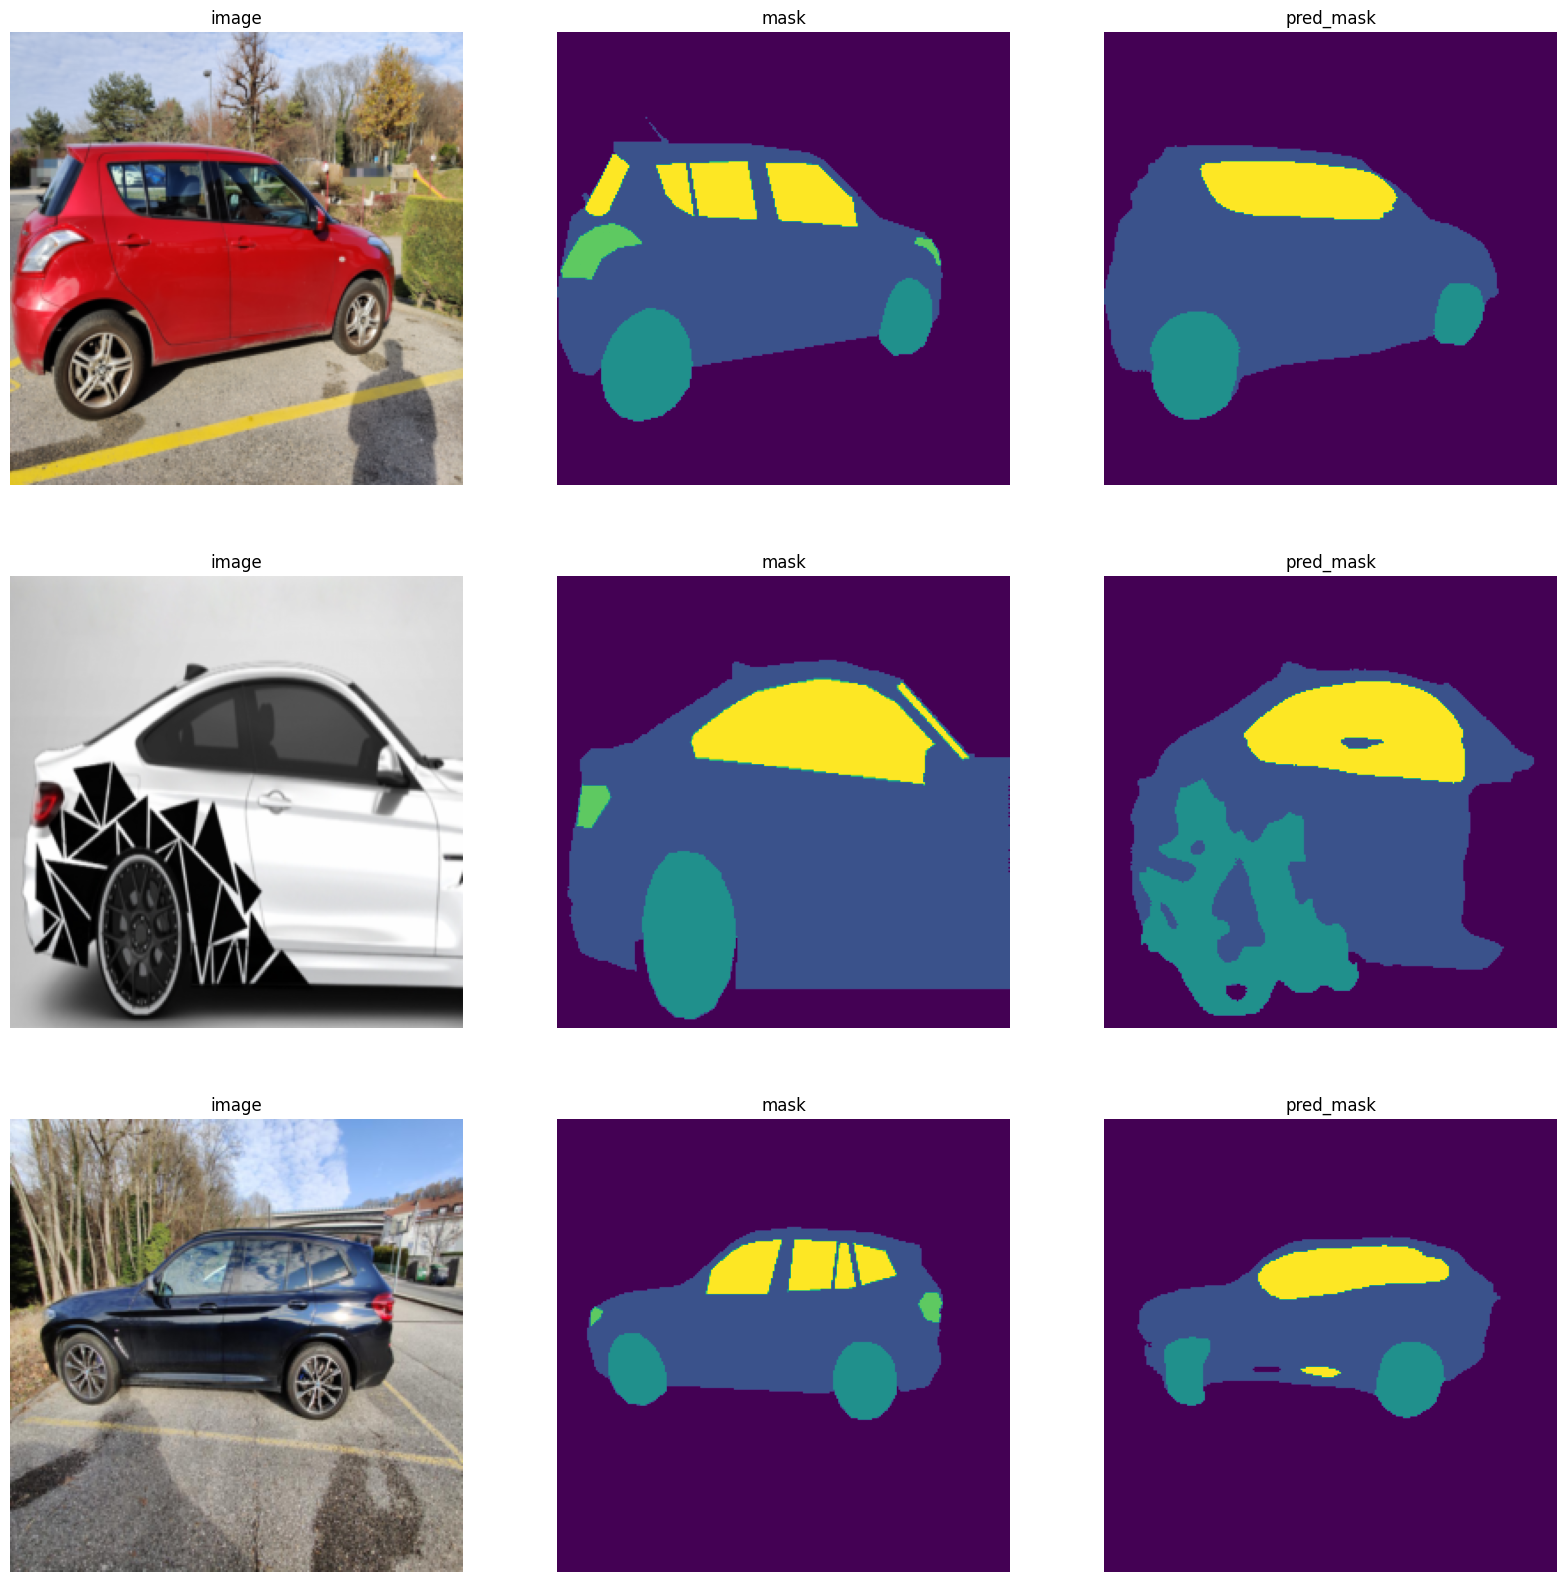

In [14]:
#pred and view image,mask,pred_mask
model.eval()
model.to(device)
fig,ax=plt.subplots(nrows=3,ncols=3,figsize=(20,20))
for i,data in enumerate(test_dataloader):
    images,masks=data
    images=images.to(device)
    masks=masks.to(device)
    with torch.no_grad():
        outputs=model(images)
        outputs=torch.argmax(outputs, dim=1)
    
    for i in range(3):
        ax[i,0].set_title('image')
        ax[i,0].set_axis_off()
        ax[i,0].imshow(images[i].cpu().permute(1,2,0))
        ax[i,1].set_title('mask')
        ax[i,1].set_axis_off()
        ax[i,1].imshow(masks[i].cpu())
        ax[i,2].set_title('pred_mask')
        ax[i,2].set_axis_off()
        ax[i,2].imshow(outputs[i].cpu())
    
    plt.show()
    break